# Duomenu aibes aprasymas, transformacijos

## Importuojame paketus, paruošiame grafikų stilių

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('bmh')
plt.rcParams['axes.facecolor'] = 'white'

## Importuojam duomenis

In [11]:
df = pd.read_csv(
    'aisdk-2026-02-05.csv',
    engine='pyarrow'
)

In [12]:
df.info()

<class 'pandas.DataFrame'>
RangeIndex: 15750590 entries, 0 to 15750589
Data columns (total 26 columns):
 #   Column                          Dtype  
---  ------                          -----  
 0   # Timestamp                     str    
 1   Type of mobile                  str    
 2   MMSI                            int64  
 3   Latitude                        float64
 4   Longitude                       float64
 5   Navigational status             str    
 6   ROT                             float64
 7   SOG                             float64
 8   COG                             float64
 9   Heading                         float64
 10  IMO                             str    
 11  Callsign                        str    
 12  Name                            str    
 13  Ship type                       str    
 14  Cargo type                      str    
 15  Width                           float64
 16  Length                          float64
 17  Type of position fixing device  str 

## Filtruojam geografinį regioną, navigacinį statusą, `Type of mobile`

In [13]:
df_filtered = df[
    df['Latitude'].between(54, 56) &
    df['Longitude'].between(12, 17) &
    (df['Navigational status'] == 'Under way using engine') &
    (df['Type of mobile'] == 'Class A')
].copy(deep=True)

del df

## Ištiriam nelogiškas ar nereikalingas reikšmes

In [14]:
df_filtered['Ship type'].value_counts()

Ship type
Cargo              684262
Passenger          263383
Tanker             246091
Pilot              110811
SAR                 92871
Fishing             59486
Other               45911
Dredging            41171
HSC                 40135
Undefined           38660
Tug                 38111
Towing              12116
Spare 1             11088
Law enforcement      8943
Military              153
Name: count, dtype: int64

> `Undefined` nereikia: mums reikia tik laivų, kuriu tipas yra žinomas, kad juos galėtume klasifikuoti, klasterizuoti ir t.t.

In [15]:
df_filtered = df_filtered[ ~(df_filtered['Ship type'] == 'Undefined') ]

In [16]:
numerical = ['Latitude', 'Longitude', 'ROT', 'SOG', 'COG', 'Heading', 'Width', 'Length', 'Draught', 'A', 'B', 'C', 'D']
df_filtered[numerical].max()

Latitude      55.999998
Longitude     16.793983
ROT          697.500000
SOG          102.200000
COG          359.900000
Heading      359.000000
Width         48.000000
Length       293.000000
Draught       14.700000
A            231.000000
B            205.000000
C             27.000000
D             36.000000
dtype: float64

In [17]:
df_filtered[numerical].min()

Latitude      54.004753
Longitude     12.000000
ROT         -231.400000
SOG            0.000000
COG            0.000000
Heading        0.000000
Width          3.000000
Length         8.000000
Draught        0.200000
A              1.000000
B              1.000000
C              1.000000
D              1.000000
dtype: float64

<Axes: xlabel='SOG', ylabel='Ship type'>

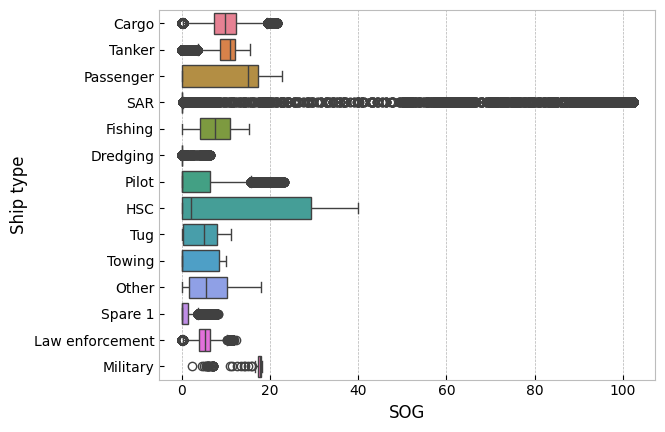

In [18]:
sns.boxplot(y='Ship type', x='SOG', hue='Ship type', data=df_filtered)

> Nelogiškai didelis SOG (100 mazgų ~ 185 kmh) yra paieškos ir gelbėjimo (*angl. Save and rescue, SAR*) laivo, kas nėra nelogiškas greitis

## Transformacijos

In [19]:
df_filtered['COG'] = df_filtered['COG'].apply( lambda x: x if x < 180.0 else 360 - x)
df_filtered['Heading'] = df_filtered['COG'].apply( lambda x: x if x < 180.0 else 360 - x)

In [20]:
relevant_cols = ['# Timestamp', 'MMSI', 'Ship type', 'Latitude', 'Longitude', 'ROT', 'SOG', 'COG', 'Heading']
df_filtered = df_filtered[ relevant_cols ]

In [21]:
df_filtered

,# Timestamp,MMSI,Ship type,Latitude,Longitude,ROT,SOG,COG,Heading
1086,05/02/2026 00:00:06,538006432,Cargo,55.447433,12.665065,0.0,13.3,169.6,169.6
1087,05/02/2026 00:00:06,538006432,Cargo,55.447433,12.665065,0.0,13.3,169.6,169.6
1448,05/02/2026 00:00:08,218058660,Cargo,54.687717,12.579850,0.0,6.5,57.1,57.1
1623,05/02/2026 00:00:09,613961020,Tanker,55.320932,14.409558,1.1,12.0,140.0,140.0
1658,05/02/2026 00:00:09,219002857,Passenger,55.679187,12.593510,NaN,0.0,96.8,96.8
...,...,...,...,...,...,...,...,...,...
15750547,05/02/2026 23:59:58,219002857,Passenger,55.679142,12.593488,NaN,0.0,94.3,94.3
15750556,05/02/2026 23:59:58,215903000,Tanker,55.459912,14.684945,-11.4,7.2,116.5,116.5
15750557,05/02/2026 23:59:58,219927000,Cargo,55.704667,15.719450,-5.4,18.9,101.4,101.4
15750566,05/02/2026 23:59:58,212584000,Cargo,55.736198,15.468068,0.0,10.8,125.4,125.4


In [22]:
df_filtered.to_csv('filtered-df.csv', index=False)

# main

### Bibliotekos

In [23]:
import pandas as pd
import numpy as np
import geopandas as gpd

import seaborn as sns
import matplotlib.pyplot as plt
import contextily as cx

### Duomenų importavimas

In [24]:
data = pd.read_csv('./filtered-df.csv', parse_dates=['# Timestamp'])

### Rinkinio peržiūra

In [25]:
data = data.sort_values(['MMSI', '# Timestamp'])

In [26]:
data.info()

<class 'pandas.DataFrame'>
Index: 1654532 entries, 268987 to 1654471
Data columns (total 9 columns):
 #   Column       Non-Null Count    Dtype         
---  ------       --------------    -----         
 0   # Timestamp  1654532 non-null  datetime64[us]
 1   MMSI         1654532 non-null  int64         
 2   Ship type    1654532 non-null  str           
 3   Latitude     1654532 non-null  float64       
 4   Longitude    1654532 non-null  float64       
 5   ROT          1273650 non-null  float64       
 6   SOG          1652421 non-null  float64       
 7   COG          1608231 non-null  float64       
 8   Heading      1608231 non-null  float64       
dtypes: datetime64[us](1), float64(6), int64(1), str(1)
memory usage: 135.6 MB


In [27]:
data.head()

,# Timestamp,MMSI,Ship type,Latitude,Longitude,ROT,SOG,COG,Heading
268987,2026-05-02 03:49:44,111219502,SAR,55.648463,12.134265,NaN,102.2,9.4,9.4
268988,2026-05-02 03:49:44,111219502,SAR,55.648463,12.134265,NaN,102.2,9.4,9.4
268989,2026-05-02 03:49:44,111219502,SAR,55.648463,12.134265,NaN,102.2,9.4,9.4
268990,2026-05-02 03:49:44,111219502,SAR,55.648463,12.134265,NaN,102.2,9.4,9.4
268991,2026-05-02 03:49:44,111219502,SAR,55.648463,12.134265,NaN,102.2,9.4,9.4


In [28]:
ships_missing_sog = data.groupby('MMSI')['SOG'].apply(lambda x: x.isna().sum()) != 0

In [29]:
ships_missing_sog.index[ships_missing_sog == True]

Index([111219502, 210674000, 218003000, 219001058, 219003452, 219008000,
       219019015, 219385000, 230642000, 230663000, 230712000, 244630415,
       244850116, 245399000, 255802870, 257759000, 265514800, 311027600,
       538010807],
      dtype='int64', name='MMSI')

In [30]:
data[data.MMSI == 210674000][data[data.MMSI == 210674000]['SOG'].isna()]

,# Timestamp,MMSI,Ship type,Latitude,Longitude,ROT,SOG,COG,Heading
606061,2026-05-02 08:39:19,210674000,Cargo,55.742467,15.483258,0.0,NaN,NaN,NaN
623230,2026-05-02 08:55:39,210674000,Cargo,55.721898,15.420057,0.0,NaN,NaN,NaN
623395,2026-05-02 08:55:49,210674000,Cargo,55.721898,15.420057,0.0,NaN,NaN,NaN
624883,2026-05-02 08:57:19,210674000,Cargo,55.720207,15.414662,0.0,NaN,NaN,NaN
625042,2026-05-02 08:57:28,210674000,Cargo,55.720207,15.414662,0.0,NaN,NaN,NaN
625245,2026-05-02 08:57:39,210674000,Cargo,55.719448,15.412403,0.0,NaN,NaN,NaN
625415,2026-05-02 08:57:48,210674000,Cargo,55.719448,15.412403,0.0,NaN,NaN,NaN
625590,2026-05-02 08:57:59,210674000,Cargo,55.718942,15.410920,0.0,NaN,NaN,NaN
646419,2026-05-02 09:18:09,210674000,Cargo,55.693310,15.334287,NaN,NaN,NaN,NaN
646794,2026-05-02 09:18:29,210674000,Cargo,55.692957,15.333230,0.0,NaN,NaN,NaN


<Axes: xlabel='SOG', ylabel='Count'>

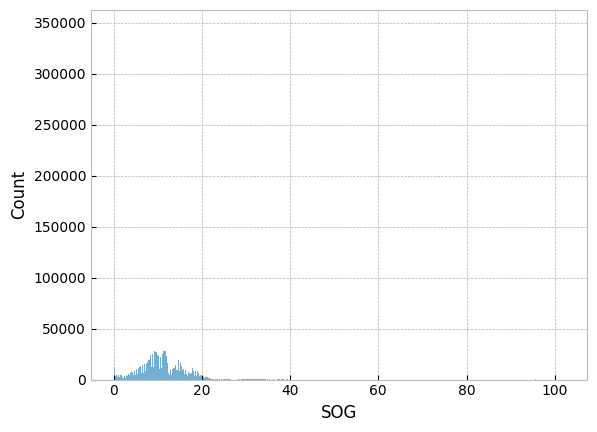

In [31]:
sns.histplot(data=data.SOG)

<Axes: xlabel='ROT', ylabel='Count'>

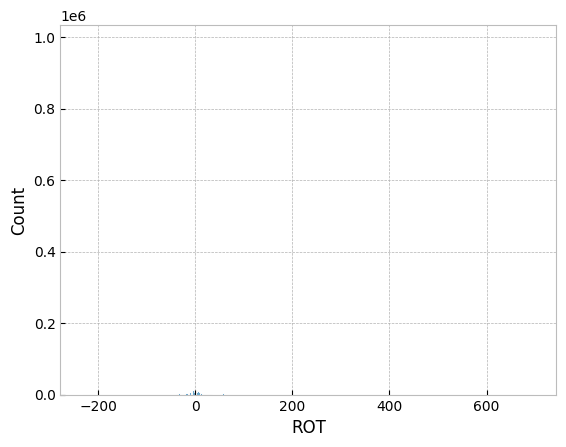

In [32]:
sns.histplot(data=data.ROT)

<Axes: xlabel='COG', ylabel='Count'>

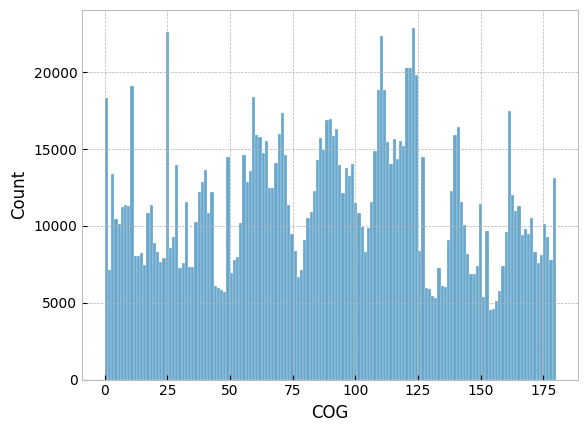

In [33]:
sns.histplot(data=data.COG)

In [34]:
gdf = gpd.GeoDataFrame(
    data, geometry=gpd.points_from_xy(data.Longitude, data.Latitude), crs="EPSG:4326"
)

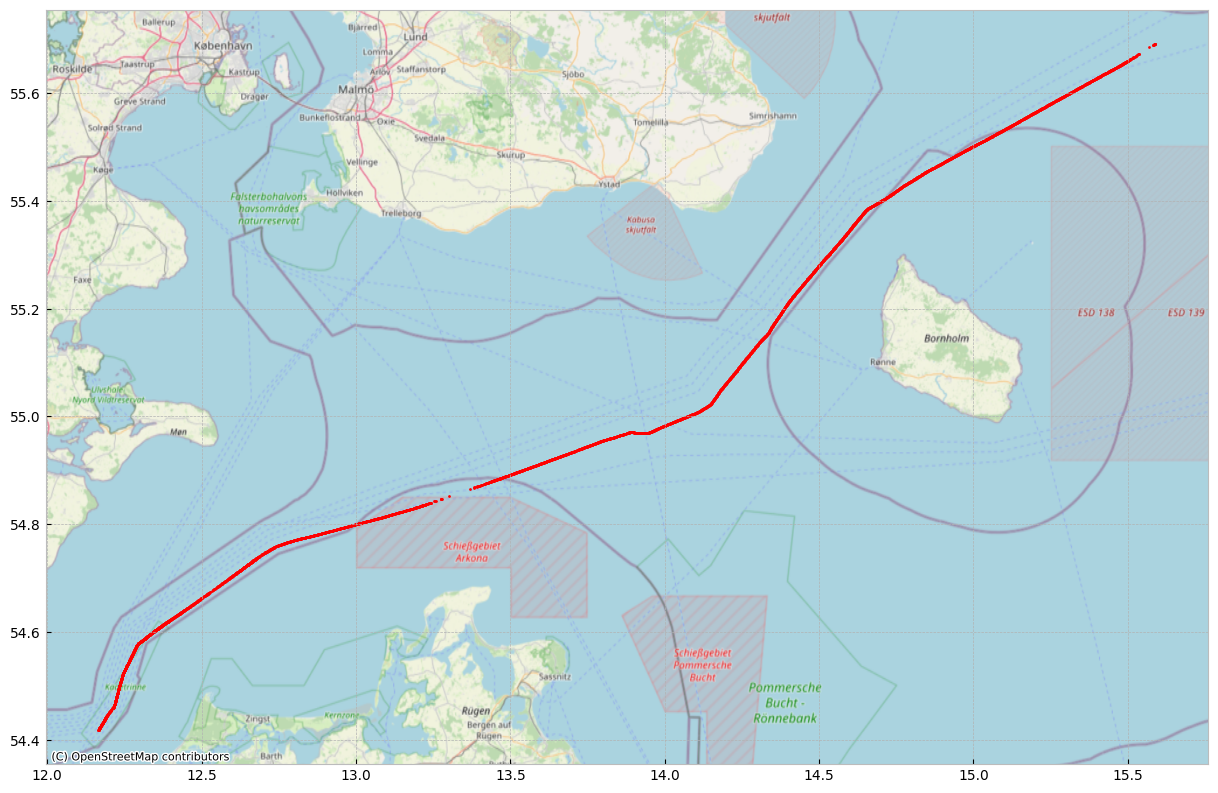

In [35]:
fig, ax = plt.subplots(1, 1, figsize=(15, 15))

gdf[gdf.MMSI == 538007403].plot(ax=ax, markersize=2, color='red')

cx.add_basemap(ax, crs=gdf.crs, source=cx.providers.OpenStreetMap.Mapnik, zoom=9)

In [36]:
corr = data.select_dtypes(include=['float64']).corr(method='spearman')

In [37]:
corr

,Latitude,Longitude,ROT,SOG,COG,Heading
Latitude,1.000000,0.132702,-0.002542,-0.275066,0.014639,0.014639
Longitude,0.132702,1.000000,0.000034,-0.026392,-0.014992,-0.014992
ROT,-0.002542,0.000034,1.000000,-0.001729,-0.005235,-0.005235
SOG,-0.275066,-0.026392,-0.001729,1.000000,0.142481,0.142481
COG,0.014639,-0.014992,-0.005235,0.142481,1.000000,1.000000
Heading,0.014639,-0.014992,-0.005235,0.142481,1.000000,1.000000


<Axes: >

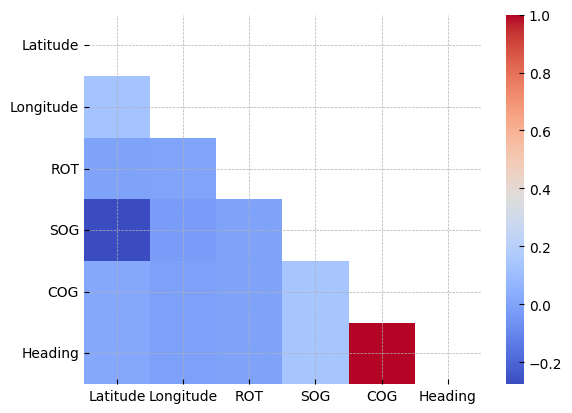

In [38]:
mask = np.triu(np.ones_like(corr, dtype=bool))

sns.heatmap(corr,
            mask=mask,
            cmap='coolwarm',
            xticklabels=True,
            yticklabels=True)

# Aprasomoji statistika, tankiai, grafikai, isskirtys

## Aprasomoji statistika

In [49]:
numeric_cols = data.select_dtypes(include='number')

desc_stats = pd.DataFrame({
    'min': numeric_cols.min(),
    'Q1': numeric_cols.quantile(0.25),
    'median': numeric_cols.median(),
    'mean': numeric_cols.mean(),
    'Q3': numeric_cols.quantile(0.75),
    'max': numeric_cols.max(),
    'variance': numeric_cols.var(),
    'std_dev': numeric_cols.std()
})

pd.options.display.float_format = '{:.3f}'.format
print(desc_stats)

                    min            Q1        median          mean  \
MMSI      111219502.000 219016663.000 245399000.000 276341531.111   
Latitude         54.005        54.785        55.265        55.208   
Longitude        12.000        12.663        12.977        13.425   
ROT            -231.400         0.000         0.000         0.014   
SOG               0.000         3.000         9.200         9.060   
COG               0.000        49.300        90.200        88.659   
Heading           0.000        49.300        90.200        88.659   

                     Q3           max              variance       std_dev  
MMSI      265797590.000 667002348.000 11877703940303292.000 108984879.411  
Latitude         55.597        56.000                 0.210         0.459  
Longitude        14.333        16.794                 1.105         1.051  
ROT               0.000       697.500                23.039         4.800  
SOG              12.700       102.200                81.426        

## Tankio grafikai pagal laivo tipa

### pagal SOG

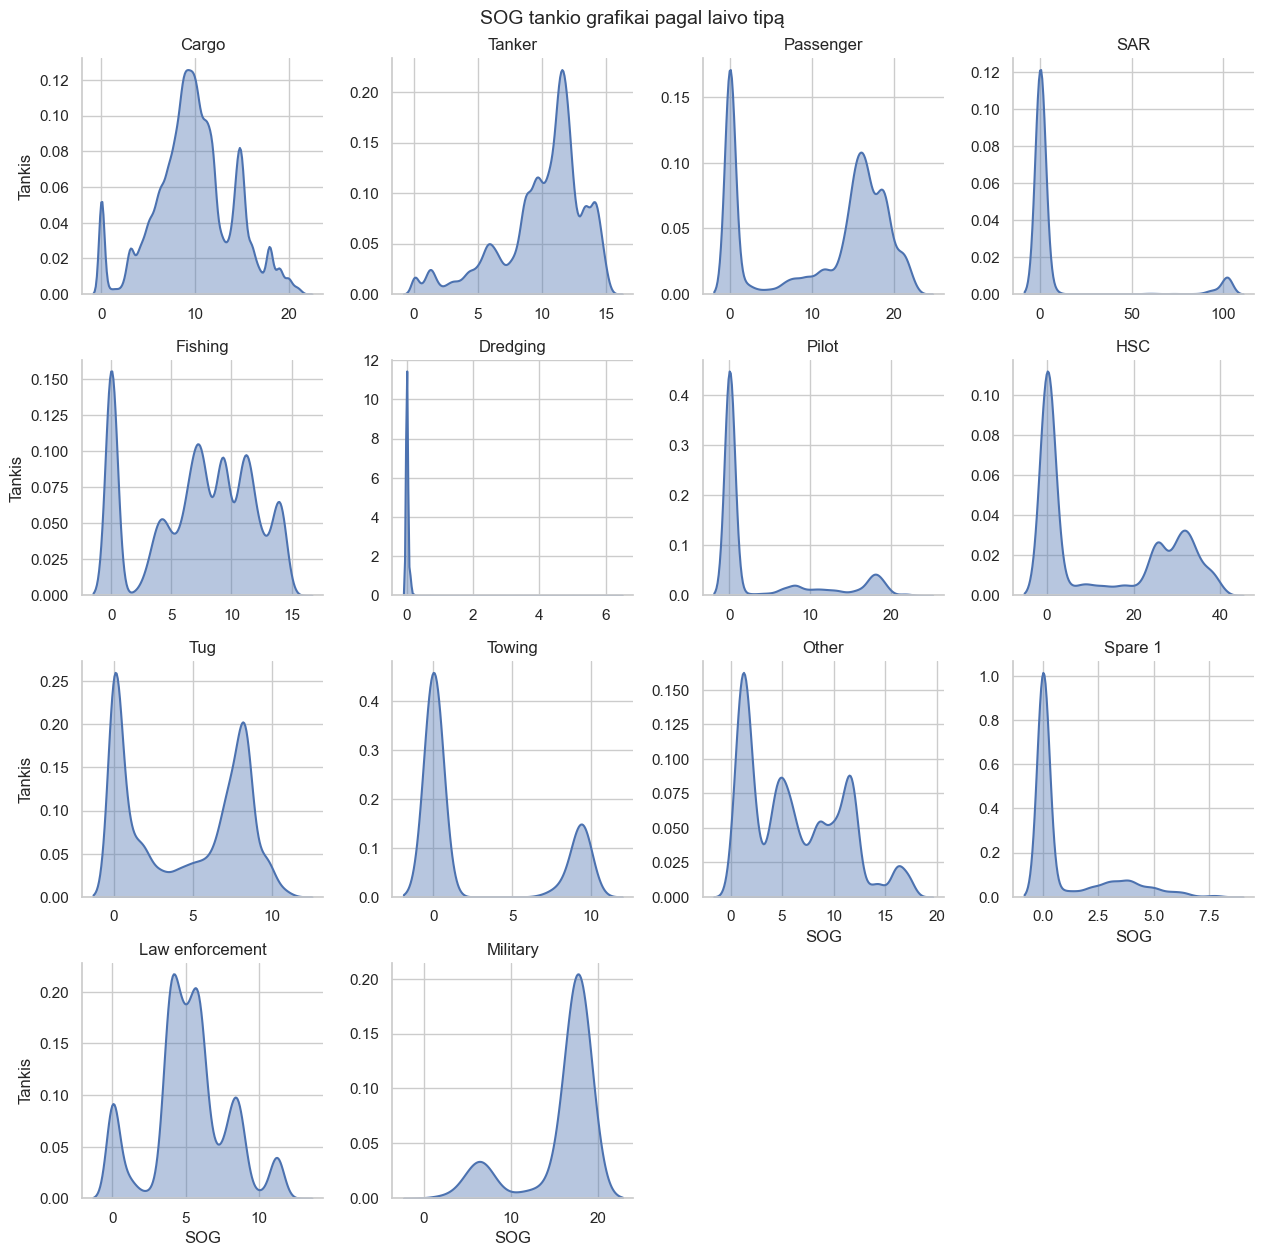

In [71]:
import seaborn as sns
import matplotlib.pyplot as plt

dfp = df_filtered.dropna(subset=["Ship type", "SOG"]).copy()
dfp["Ship type"] = dfp["Ship type"].astype(str).str.strip()

sns.set_theme(style="whitegrid")

g = sns.FacetGrid(
    dfp,
    col="Ship type",
    col_wrap=4,
    height=3.2,
    sharex=False,   # kiekvienas turi savo X mastelį
    sharey=False    # kiekvienas turi savo Y mastelį
)

g.map_dataframe(
    sns.kdeplot,
    x="SOG",
    fill=True,
    alpha=0.4,
    linewidth=1.5
)

g.set_titles("{col_name}")
g.set_axis_labels("SOG", "Tankis")

plt.subplots_adjust(top=0.90)
g.fig.suptitle("SOG tankio grafikai pagal laivo tipą", fontsize=14)

plt.tight_layout()
plt.show()

### pagal ROT

/Users/vilte/Desktop/6 sem/vizualizavimas/1 Lab/Laboratorinis/venv/lib/python3.13/site-packages/seaborn/axisgrid.py:854: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  func(*plot_args, **plot_kwargs)
/Users/vilte/Desktop/6 sem/vizualizavimas/1 Lab/Laboratorinis/venv/lib/python3.13/site-packages/seaborn/axisgrid.py:854: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  func(*plot_args, **plot_kwargs)
/Users/vilte/Desktop/6 sem/vizualizavimas/1 Lab/Laboratorinis/venv/lib/python3.13/site-packages/seaborn/axisgrid.py:854: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  func(*plot_args, **plot_kwargs)
/Users/vilte/Desktop/6 sem/vizualizavimas/1 Lab/Laboratorinis/venv/lib/python3.13/site-packages/seaborn/axisgrid.py:854: UserWarning: Dataset has 0 variance; skipping density estimate. Pa

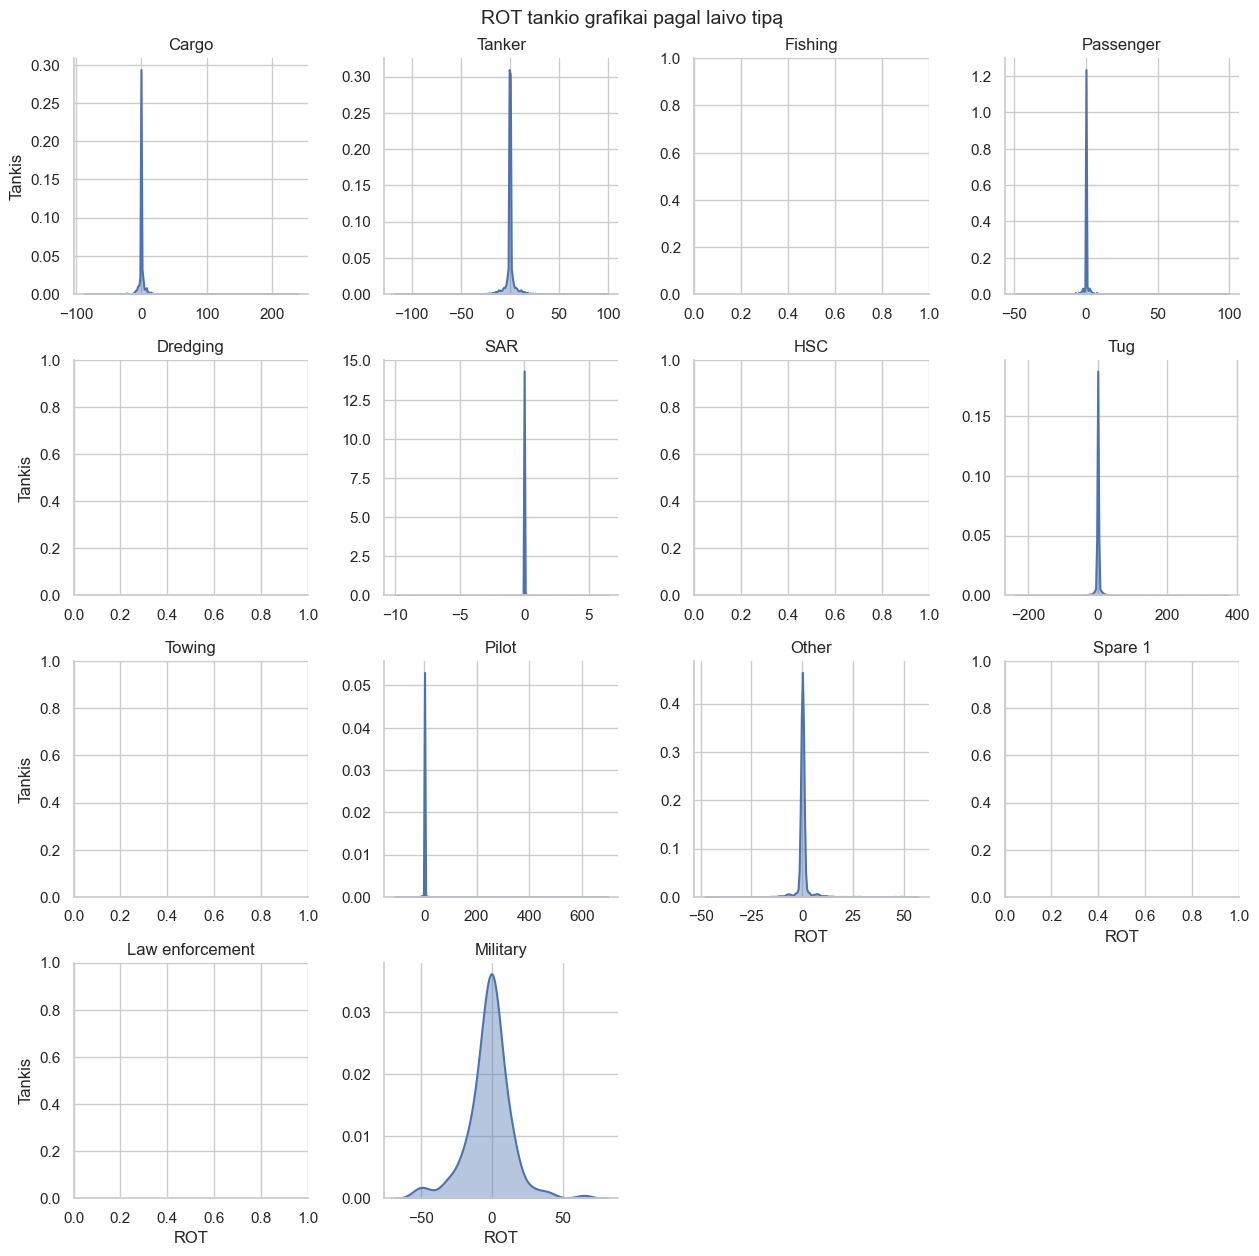

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

var = "ROT"  

dfp = df_filtered.dropna(subset=["Ship type", var]).copy()
dfp["Ship type"] = dfp["Ship type"].astype(str).str.strip()

sns.set_theme(style="whitegrid")

g = sns.FacetGrid(
    dfp,
    col="Ship type",
    col_wrap=4,
    height=3.2,
    sharex=False,
    sharey=False
)

g.map_dataframe(
    sns.kdeplot,
    x=var,
    fill=True,
    alpha=0.4,
    linewidth=1.5
)

g.set_titles("{col_name}")
g.set_axis_labels(var, "Tankis")

plt.subplots_adjust(top=0.90)
g.fig.suptitle(f"{var} tankio grafikai pagal laivo tipą", fontsize=14)

plt.tight_layout()
plt.show()

## isskirtys

In [82]:
import pandas as pd

numerical_cols = ["Latitude", "Longitude", "ROT", "SOG", "COG", "Heading"]

outlier_summary = {}

for col in numerical_cols:
    df_col = data[col].dropna()
    
    Q1 = df_col.quantile(0.25)
    Q3 = df_col.quantile(0.75)
    IQR = Q3 - Q1
    
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outliers = data[(data[col] < lower_bound) | (data[col] > upper_bound)]
    
    outlier_summary[col] = len(outliers)

print(outlier_summary)

{'Latitude': 0, 'Longitude': 0, 'ROT': 294432, 'SOG': 19899, 'COG': 0, 'Heading': 0}


In [75]:
for col in numerical_cols:
    df_col = data[col].dropna()
    
    Q1 = df_col.quantile(0.25)
    Q3 = df_col.quantile(0.75)
    IQR = Q3 - Q1
    
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    
    outliers = data[(data[col] < lower) | (data[col] > upper)]
    
    print(f"\n{col}")
    print("Lower:", round(lower,2))
    print("Upper:", round(upper,2))
    print("Min:", round(df_col.min(),2))
    print("Max:", round(df_col.max(),2))
    print("Outliers:", len(outliers))


Latitude
Lower: 53.57
Upper: 56.81
Min: 54.0
Max: 56.0
Outliers: 0

Longitude
Lower: 10.16
Upper: 16.84
Min: 12.0
Max: 16.79
Outliers: 0

ROT
Lower: 0.0
Upper: 0.0
Min: -231.4
Max: 697.5
Outliers: 294432

SOG
Lower: -11.55
Upper: 27.25
Min: 0.0
Max: 102.2
Outliers: 19899

COG
Lower: -62.9
Upper: 236.3
Min: 0.0
Max: 180.0
Outliers: 0

Heading
Lower: -62.9
Upper: 236.3
Min: 0.0
Max: 180.0
Outliers: 0


Taikant IQR metodą nustatyta, kad kintamasis ROT turi labai daug išskirčių. Tačiau tai paaiškinama tuo, kad didžioji dalis stebėjimų turi reikšmę 0 (laivas juda tiesiai), todėl kvartilių intervalas lygus nuliui ir visi nenuliniai stebėjimai klasifikuojami kaip išskirtys. Todėl IQR metodas šiam kintamajam nėra tinkamas.

In [80]:
from scipy.stats import zscore
data["ROT_z"] = zscore(data["ROT"], nan_policy="omit")
rot_outliers = data[abs(data["ROT_z"]) > 3]

print("ROT outliers count:", len(rot_outliers))
rot_outliers[["ROT", "ROT_z"]].head()

ROT outliers count: 29205


,ROT,ROT_z
1294798,-57.900,-12.066
1294799,-57.900,-12.066
1350534,-57.900,-12.066
1350535,-57.900,-12.066
1350536,-57.900,-12.066


In [79]:
print("Min ROT:", data["ROT"].min())
print("Max ROT:", data["ROT"].max())

print("Z-score threshold ≈ ±3")
print("Actual Z min:", data["ROT_z"].min())
print("Actual Z max:", data["ROT_z"].max())

Min ROT: -231.4
Max ROT: 697.5
Z-score threshold ≈ ±3
Actual Z min: -54.94999650407664
Actual Z max: 165.62327026183794


In [81]:
rot_extreme = data[abs(data["ROT"]) > 200]
print(len(rot_extreme))

32


Kintamajam ROT taikant Z-score metodą (|z| > 3) nustatyti 29 205 atsiskyrėliai. Tačiau dėl labai asimetriško pasiskirstymo ir didelio nulinių reikšmių skaičiaus šis metodas pervertina anomalijų skaičių. Taikant fizinę ribą |ROT| > 200°/min nustatyti tik 32 stebėjimai, kurie labiau tikėtini kaip sensoriaus matavimo klaidos arba ekstremalūs manevrai.